In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("D:\PR Project\ICBK Historical Data.csv")

df['Date'] = pd.to_datetime(df['Date'])

df = df.sort_values('Date')

data = df[['Price', 'Open', 'High', 'Low']].values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

C:\Users\Kalyan GVKK\AppData\Local\Temp\ipykernel_9124\375816703.py:7: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])


In [2]:
from hmmlearn.hmm import GaussianHMM

hmm_model = GaussianHMM(n_components=4, covariance_type='diag', n_iter=1000)
hmm_model.fit(train_data)

hidden_states = hmm_model.predict(train_data)

train_data_with_states = np.hstack([train_data, hidden_states.reshape(-1, 1)])
test_data_with_states = np.hstack([test_data, hmm_model.predict(test_data).reshape(-1, 1)])


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length][0]) 
    return np.array(sequences), np.array(labels)

seq_length = 50  
X_train, y_train = create_sequences(train_data_with_states, seq_length)
X_test, y_test = create_sequences(test_data_with_states, seq_length)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=32))
model.add(Dense(units=1)) 

model.compile(optimizer='adam', loss='mean_squared_error')

In [4]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
124/124 [==============================] - 11s 49ms/step - loss: 0.0015 - val_loss: 0.0101
Epoch 2/20
124/124 [==============================] - 4s 36ms/step - loss: 7.3527e-04 - val_loss: 0.0095
Epoch 3/20
124/124 [==============================] - 5s 38ms/step - loss: 7.5126e-04 - val_loss: 0.0116
Epoch 4/20
124/124 [==============================] - 5s 39ms/step - loss: 6.5919e-04 - val_loss: 0.0085
Epoch 5/20
124/124 [==============================] - 5s 39ms/step - loss: 6.5465e-04 - val_loss: 0.0145
Epoch 6/20
124/124 [==============================] - 5s 37ms/step - loss: 6.1734e-04 - val_loss: 0.0128
Epoch 7/20
124/124 [==============================] - 5s 37ms/step - loss: 5.8761e-04 - val_loss: 0.0123
Epoch 8/20
124/124 [==============================] - 5s 39ms/step - loss: 5.0275e-04 - val_loss: 0.0100
Epoch 9/20
124/124 [==============================] - 6s 46ms/step - loss: 5.1865e-04 - val_loss: 0.0124
Epoch 10/20
124/124 [==============================] - 5s 

In [5]:
predicted_prices = model.predict(X_test)

predicted_prices = scaler.inverse_transform(np.hstack([predicted_prices, np.zeros((predicted_prices.shape[0], 3))]))[:, 0]

30/30 [==============================] - 1s 13ms/step


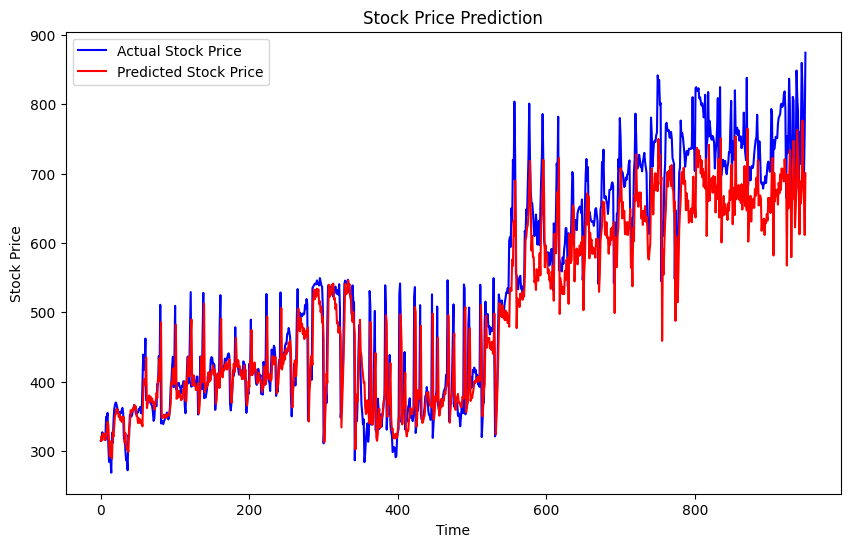

In [6]:
import matplotlib.pyplot as plt

actual_prices = df['Price'].values[train_size + seq_length:]

plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_prices, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [7]:
model.save("newModel.h5")

c:\Users\Kalyan GVKK\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#Make predictions for Oct to Jan 2025 and validate